In [301]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.base import TransformerMixin

import regex as re

random_state = 11

In [302]:
master = pd.read_csv('~/downloads/new_beds.csv')

In [303]:
master = master.drop(columns = 'Unnamed: 0')

In [304]:
master.head()

,county_x,state,id,population,estimate!!race!!total population!!one race,estimate!!race!!total population!!two or more races,estimate!!race!!total population!!one race.1,estimate!!race!!total population!!one race!!white,estimate!!race!!total population!!one race!!black or african american,estimate!!race!!total population!!one race!!american indian and alaska native,...,"cert nurse midwvs,ft oth emptyp_y",nursing facilities total beds,nurse practitioners_y,"advpractnurs midwve,male w/npi",st_num,countyfips,beds,case_per_pop,beds_per_pop,beds_per_case
0,autauga county,AL,1001,55200,54170,1030,54170,42437,10565,159,...,0.0,0.0,0.0,0.0,1,1001,85.0,0.001214,0.001540,1.268657
1,baldwin county,AL,1003,208107,204535,3572,204535,179526,19764,1522,...,0.0,0.0,0.0,0.0,1,1003,386.0,0.000999,0.001855,1.855769
2,barbour county,AL,1005,25782,25429,353,25429,12216,12266,72,...,0.0,0.0,0.0,0.0,1,1005,74.0,0.002056,0.002870,1.396226
3,bibb county,AL,1007,22527,22340,187,22340,17268,5018,8,...,0.0,0.0,0.0,0.0,1,1007,35.0,0.001953,0.001554,0.795455
4,blount county,AL,1009,57645,56710,935,56710,55054,862,141,...,0.0,0.0,0.0,0.0,1,1009,25.0,0.000763,0.000434,0.568182


(array([3.051e+03, 4.200e+01, 1.100e+01, 1.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.        , 0.01415439, 0.02830879, 0.04246318, 0.05661757,
        0.07077196, 0.08492636, 0.09908075, 0.11323514, 0.12738953,
        0.14154393]),
 <a list of 10 Patch objects>)

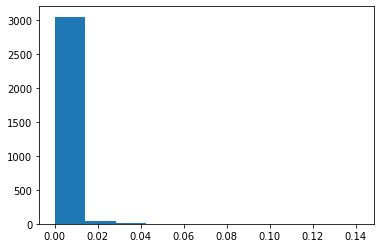

In [305]:
plt.hist(master['case_per_pop'])

In [306]:
master['case_per_pop'].describe()

count    3108.000000
mean        0.001994
std         0.004738
min         0.000000
25%         0.000333
50%         0.000784
75%         0.001943
max         0.141544
Name: case_per_pop, dtype: float64

In [307]:
.95/2/2

0.2375

In [308]:
master.shape[0] * 0.2375

738.15

In [309]:
master.shape[0] - 739

2369

In [310]:
master.shape[0] * .1

310.8

In [311]:
above_std_1 = master.sort_values(by = 'case_per_pop', ascending = False).head(739)

In [312]:
above_std_1['case_per_pop'] = ((above_std_1['case_per_pop'].values *0) +1).astype(int)

In [313]:
below = master.sort_values(by = 'case_per_pop', ascending = False).tail(2369)

In [314]:
below['case_per_pop'] = ((below['case_per_pop'].values *0)).astype(int)

In [315]:
master['case_per_pop'] = pd.concat([above_std_1['case_per_pop'],below['case_per_pop']])
master.head()

,county_x,state,id,population,estimate!!race!!total population!!one race,estimate!!race!!total population!!two or more races,estimate!!race!!total population!!one race.1,estimate!!race!!total population!!one race!!white,estimate!!race!!total population!!one race!!black or african american,estimate!!race!!total population!!one race!!american indian and alaska native,...,"cert nurse midwvs,ft oth emptyp_y",nursing facilities total beds,nurse practitioners_y,"advpractnurs midwve,male w/npi",st_num,countyfips,beds,case_per_pop,beds_per_pop,beds_per_case
0,autauga county,AL,1001,55200,54170,1030,54170,42437,10565,159,...,0.0,0.0,0.0,0.0,1,1001,85.0,0,0.001540,1.268657
1,baldwin county,AL,1003,208107,204535,3572,204535,179526,19764,1522,...,0.0,0.0,0.0,0.0,1,1003,386.0,0,0.001855,1.855769
2,barbour county,AL,1005,25782,25429,353,25429,12216,12266,72,...,0.0,0.0,0.0,0.0,1,1005,74.0,1,0.002870,1.396226
3,bibb county,AL,1007,22527,22340,187,22340,17268,5018,8,...,0.0,0.0,0.0,0.0,1,1007,35.0,0,0.001554,0.795455
4,blount county,AL,1009,57645,56710,935,56710,55054,862,141,...,0.0,0.0,0.0,0.0,1,1009,25.0,0,0.000434,0.568182


In [316]:
master.head()

,county_x,state,id,population,estimate!!race!!total population!!one race,estimate!!race!!total population!!two or more races,estimate!!race!!total population!!one race.1,estimate!!race!!total population!!one race!!white,estimate!!race!!total population!!one race!!black or african american,estimate!!race!!total population!!one race!!american indian and alaska native,...,"cert nurse midwvs,ft oth emptyp_y",nursing facilities total beds,nurse practitioners_y,"advpractnurs midwve,male w/npi",st_num,countyfips,beds,case_per_pop,beds_per_pop,beds_per_case
0,autauga county,AL,1001,55200,54170,1030,54170,42437,10565,159,...,0.0,0.0,0.0,0.0,1,1001,85.0,0,0.001540,1.268657
1,baldwin county,AL,1003,208107,204535,3572,204535,179526,19764,1522,...,0.0,0.0,0.0,0.0,1,1003,386.0,0,0.001855,1.855769
2,barbour county,AL,1005,25782,25429,353,25429,12216,12266,72,...,0.0,0.0,0.0,0.0,1,1005,74.0,1,0.002870,1.396226
3,bibb county,AL,1007,22527,22340,187,22340,17268,5018,8,...,0.0,0.0,0.0,0.0,1,1007,35.0,0,0.001554,0.795455
4,blount county,AL,1009,57645,56710,935,56710,55054,862,141,...,0.0,0.0,0.0,0.0,1,1009,25.0,0,0.000434,0.568182


In [317]:
master['beds_per_pop'].value_counts()

0.000000    652
0.002416      2
0.005938      2
0.001425      2
0.002451      2
           ... 
0.011798      1
0.002766      1
0.006134      1
0.010653      1
0.016191      1
Name: beds_per_pop, Length: 2449, dtype: int64

In [318]:
# master.to_csv('~/documents/case_per_pop_dummied_std_1.csv')

In [319]:
master['case_per_pop'].value_counts(normalize = True)

0    0.762227
1    0.237773
Name: case_per_pop, dtype: float64

In [320]:
master['case_per_pop'].value_counts(normalize = True)

0    0.762227
1    0.237773
Name: case_per_pop, dtype: float64

Since we are using accuracy as our metric, our baseline is a score of .76227, which would occur if our model predicted an area to not be a coronavirus hotspot.

In [322]:
X = master.drop(columns = ['total_covid', 'deaths', 'county_x', 'county_y', 'state', 'id', 'population', 
                           'case_per_pop', 'beds_per_case'])
y = master['case_per_pop']


ss = StandardScaler()

X_ss = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_ss, y, random_state = 11, stratify = y)

In [323]:
pipe = Pipeline([ #instantiate transformers and model
    ('lr', LogisticRegression(random_state = 11))
])

# set hyperparameters

pipe_params = {'lr__dual' : [True, False],
               'lr__class_weight' : ['dict', 'balanced', None],
              'lr__solver': ['liblinear', 'lbfgs', None],
              'lr__penalty': ['l1', 'l2', 'none'] # running this with the lasso and ridge techniques by applying a penalty, also running with no penalty
              }

gs = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2   
                    )

In [324]:
logreg_model = gs.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalt

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit fail

[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dua

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'd

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/l

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/l

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.7s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.7s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.6s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.6s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only dual=False, got dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/e

[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.6s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   1.1s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   1.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   1.7s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   1.5s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   1.8s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/l

[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_wei

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/l

[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.7s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.6s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.9s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   1.1s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only dual=False, got dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/e

[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.7s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   1.6s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   1.1s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   1.3s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   1.2s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   1.5s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.4s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/l

[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.5s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.5s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.5s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.4s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.4s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done 270 out of 270 | elap

[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s


In [325]:
logreg_train_score = logreg_model.score(X_train, y_train)

In [326]:
logreg_test_score = logreg_model.score(X_test, y_test)

In [327]:
logreg_model.best_params_

{'lr__class_weight': None,
 'lr__dual': False,
 'lr__penalty': 'l1',
 'lr__solver': 'liblinear'}

In [328]:
cross_val_score(logreg_model.best_estimator_, X, y).mean()

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7532431354883473

In [329]:
coefs = logreg_model.best_estimator_.steps[0][1].coef_

In [330]:
coef_df = pd.DataFrame(coefs).T

In [331]:
coef_df['coefficients'] = list(X.columns)

In [332]:
coef_df.rename(columns=({0: 'coefficient',
                        'coefficients': 'feature'}), inplace=True)

In [333]:
coef_df.sort_values(by = 'coefficient')

,coefficient,feature
71,-2.329513,estimate!!sex and age!!total population!!75 to...
64,-1.454859,estimate!!sex and age!!total population!!20 to...
16,-1.044095,estimate!!race!!total population!!one race!!as...
26,-0.795239,estimate!!race!!total population!!two or more ...
38,-0.757097,estimate!!hispanic or latino and race!!total p...
...,...,...
72,0.730177,estimate!!sex and age!!total population!!85 ye...
41,0.885237,estimate!!hispanic or latino and race!!total p...
67,1.188350,estimate!!sex and age!!total population!!45 to...
15,1.595458,estimate!!race!!total population!!one race!!as...


In [334]:
logreg_model.best_estimator_

Pipeline(memory=None,
         steps=[('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=11,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [335]:
logreg_train_score

0.7936507936507936

In [336]:
logreg_test_score

0.7824967824967825

In [337]:
coef_df['abs'] = abs(coef_df['coefficient'])

In [338]:
lose_these = coef_df.loc[coef_df['abs'] < 0.0000001]

In [339]:
# lose_these.to_csv('~/documents/bad_features.csv')

In [340]:
list(lose_these['feature'].values)

['estimate!!race!!total population!!one race',
 'estimate!!race!!total population!!two or more races',
 'estimate!!race!!total population!!one race.1',
 'estimate!!race!!total population!!one race!!white',
 'estimate!!race!!total population!!one race!!asian',
 'estimate!!race!!total population!!one race!!asian!!chinese',
 'estimate!!race!!total population!!one race!!native hawaiian and other pacific islander',
 'estimate!!race!!total population!!one race!!native hawaiian and other pacific islander!!native hawaiian',
 'estimate!!race!!total population!!one race!!some other race',
 'estimate!!race!!total population!!two or more races.1',
 'estimate!!race!!total population!!two or more races!!white and black or african american',
 'estimate!!race alone or in combination with one or more other races!!total population',
 'estimate!!race alone or in combination with one or more other races!!total population!!white',
 'estimate!!race alone or in combination with one or more other races!!total

In [341]:
better_master = master.drop(columns = list(lose_these['feature'].values))

In [342]:
X = better_master.drop(columns = ['total_covid', 'deaths', 'county_x', 'county_y', 'state', 'id', 'population', 
                           'case_per_pop', 'beds_per_case'])
y = better_master['case_per_pop']


ss = StandardScaler()

X_ss = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_ss, y, random_state = 11, stratify = y)

In [343]:
pipe = Pipeline([ #instantiate transformers and model
    ('lr', LogisticRegression(random_state = 11))
])

# set hyperparameters

pipe_params = {'lr__dual' : [True, False],
               'lr__class_weight' : ['dict', 'balanced', None],
              'lr__solver': ['liblinear', 'lbfgs', None],
              'lr__penalty': ['l1', 'l2', 'none'] # running this with the lasso and ridge techniques by applying a penalty, also running with no penalty
              }

gs = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2   
                    )

In [346]:
logreg_2 = gs.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalt

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit fail


[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, l

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'd

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalt

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale t

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only d


[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.8s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, to

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_w

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale t

[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/l

[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only d

[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.2s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.1s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.1s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)


[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=none, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=none, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=none, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=none, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=none, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=none, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=none, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=none, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=none, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=none, lr__solver=lbfgs, total=   0.0s
[CV] 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.1s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.1s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=None, lr__dual=Fal

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale t

[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done 270 out of 270 | elap

[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s


In [347]:
logreg_2_train_score = logreg_2.score(X_train, y_train)

In [350]:
logreg_2_test_score = logreg_2.score(X_test, y_test)

In [351]:
logreg_2.best_params_

{'lr__class_weight': None,
 'lr__dual': False,
 'lr__penalty': 'l1',
 'lr__solver': 'liblinear'}

In [352]:
cross_val_score(logreg_2.best_estimator_, X, y).mean()

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7580631799141515

In [362]:
new_coefs = logreg_2.best_estimator_.steps[0][1].coef_

In [363]:
new_coef_df = pd.DataFrame(new_coefs).T

In [364]:
new_coef_df

,0
0,0.575303
1,0.322294
2,-0.052873
3,-0.156719
4,0.220983
5,-0.185935
6,-0.359047
7,-0.315501
8,0.715899
9,1.574037


In [365]:
len(X.columns)

50

In [366]:
new_coef_df['coefficients'] = list(X.columns)

In [367]:
new_coef_df.rename(columns=({0: 'coefficient',
                        'coefficients': 'feature'}), inplace=True)

In [368]:
new_coef_df.sort_values(by = 'coefficient')

,coefficient,feature
30,-2.299993,estimate!!sex and age!!total population!!75 to...
26,-1.449515,estimate!!sex and age!!total population!!20 to...
10,-1.043965,estimate!!race!!total population!!one race!!as...
15,-0.802888,estimate!!race!!total population!!two or more ...
19,-0.754960,estimate!!hispanic or latino and race!!total p...
16,-0.609410,estimate!!race!!total population!!two or more ...
21,-0.542546,estimate!!hispanic or latino and race!!total p...
32,-0.465196,estimate!!sex and age!!total population!!media...
12,-0.363636,estimate!!race!!total population!!one race!!na...
6,-0.359047,estimate!!race!!total population!!one race!!as...


In [369]:
logreg_2.best_estimator_

Pipeline(memory=None,
         steps=[('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=11,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [373]:
print(f' Training Score: {logreg_2_train_score}')
print(f' Testing Score: {logreg_2_test_score}')



 Training Score: 0.7932217932217932
 Testing Score: 0.7824967824967825
